Choose GPU

In [1]:
import os
KAGGLE = True
if os.name == "nt":
    KAGGLE = False
print(f"KAGGLE: {KAGGLE}")
if not KAGGLE:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

KAGGLE: False


In [2]:
# general
import gc
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

from glob import glob
import random
import numpy as np
import pandas as pd
import json
from IPython.core.display import display, HTML
if KAGGLE:
    from kaggle_datasets import KaggleDatasets

# ML
from sklearn.metrics import roc_auc_score

# DL
import tensorflow as tf
import tensorflow_addons as tfa
# tf.config.optimizer.set_jit(True)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns



### Settings

In [3]:
# tf.compat.v1.disable_eager_execution()
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

In [4]:
def auto_select_accelerator():
    TPU_DETECTED = False
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        tf.keras.mixed_precision.set_global_policy("mixed_bfloat16")
        print(f"Running on TPU: {tpu.master()}")
        TPU_DETECTED = True
    except ValueError:
        strategy = tf.distribute.get_strategy()
        tf.keras.mixed_precision.set_global_policy("mixed_float16")
    num_replicas = strategy.num_replicas_in_sync
    print(f"Running on {num_replicas} replica{'s' if num_replicas > 1 else ''}")
    return strategy, TPU_DETECTED, num_replicas

## PARAMS

In [5]:
strategy, TPU_Detected, REPLICAS = auto_select_accelerator()
INPUT_DIR = "../input/g2net-gravitational-wave-detection"
MDLS_PATH = "." if KAGGLE else "../models"
# TRAIN_FILES_PATH = "../input/filtered*_tfrec"
AUTO = tf.data.experimental.AUTOTUNE
tfrec_folders = ["filtered-whitened-tfrec", "whitened-tfrec"]#["filtered-tfrec", "filtered-whitened-tfrec", "filtered-whitened-inverted-tfrec", "whitened-tfrec"]


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
Running on 1 replica


In [6]:
results_df = "no file"
if not KAGGLE:
    results_df = pd.read_csv("../models/results.csv", index_col=[0]).tail(20)
results_df

,lr,version,train_mode,batch_size,epochs,bavg_epoch,bavg_loss,bavg_auc,changelog,seed
25,0.00010,78,full,256,40,12,0.442443,0.841306,doubled last layer in all blocks. lr/10,42.0
26,0.00050,79,full,256,40,25,0.439258,0.842578,doubled last layer in all blocks doubled size ...,42.0
27,0.00050,83,full,256,40,27,0.439051,0.841536,added dropout layers to dense layers,42.0
28,0.00010,88,full,256,40,8,0.453092,0.834111,everything had 3 layers now and relu activation,42.0
29,0.00010,92,full,256,100,17,0.434836,0.832301,dropout layers,42.0
30,0.00010,110,full,256,100,11,0.470093,0.815836,dropout layers,42.0
31,0.00010,113,full,256,100,8,0.476270,0.813889,dropout layers,42.0
32,0.00002,119,full,256,100,36,0.463551,0.812370,new dataset using best model (base model with ...,42.0
33,0.00020,124,full,256,100,23,0.448196,0.827187,10x lr,42.0
34,0.00010,134,full,256,100,12,0.467185,0.826250,1/4 lr,42.0


In [7]:
if KAGGLE:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    user_credential = user_secrets.get_gcloud_credential()
    user_secrets.set_tensorflow_credential(user_credential)

In [8]:
if not os.path.exists(f"{MDLS_PATH}/results.csv"):
    VER = 1
else:
    results = pd.read_csv(f"{MDLS_PATH}/results.csv", index_col=[0])
    VER = int(results.version.max())
Params ={
    "lr": 1e-4 * REPLICAS,
    "version": VER,
    "train_mode": "full", #test, full
    "batch_size": 256 * REPLICAS,
    "epochs":100,
    "seed": 69,
    "changelog": "1/4 lr",
}
seed_everything(Params["seed"])

Make Model directory

In [9]:
VER = Params["version"]
MDL_PATH = f"{MDLS_PATH}/models_v{VER:03}"
while os.path.exists(MDL_PATH):
    VER += 1
    MDL_PATH = f"{MDLS_PATH}/models_v{VER:03}"
Params["version"]=VER
os.mkdir(MDL_PATH)

In [10]:
def random_cut(x, y):
    a = np.zeros(x.shape, dtype=np.float32)
    dt = np.random.randint(2,512)
    t0 = np.random.randint(1,dt)
    t1 = np.random.randint(0,t0)
    a[:,t1:t1+(3584)] = x[:,t0:t0+(3584)]
    a[:] *= np.array([-1 if random.random() > 0.5 else 1,-1 if random.random() > 0.5 else 1, -1 if random.random() > 0.5 else 1])
    return a,y

In [11]:
import tensorflow_datasets as tfds
input_context = tf.distribute.InputContext(
    input_pipeline_id=1,
    num_input_pipelines = 8
)
read_config= tfds.ReadConfig(
    input_context=input_context
)

def load_dataset(files, shuffle=True, ordered=False, labeled = True, repeat=True, return_labels = False, cut = False):
    if ordered:
        dataset = tf.data.TFRecordDataset(files, num_parallel_reads=None)
    else:
        dataset = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)


    def _parse_function(example_proto):
        if labeled:
            keys_to_feature = {
                "TimeSeries":tf.io.FixedLenFeature([4096,3],tf.float32),
                "Target":tf.io.FixedLenFeature([], tf.int64, default_value=0)}
            if return_labels:
                keys_to_feature["id"]=tf.io.FixedLenFeature([],tf.string, default_value="")
        else:
            keys_to_feature = {
                "TimeSeries": tf.io.FixedLenFeature([4096,3],tf.float32)
            }
        parsed_features = tf.io.parse_single_example(example_proto, keys_to_feature)
        if labeled:
            if return_labels:
                return parsed_features["TimeSeries"], parsed_features["Target"], parsed_features["id"]
            else:
                return parsed_features["TimeSeries"], parsed_features["Target"]
        else:
            return parsed_features["TimeSeries"]
    
    if not ordered:
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic=False
        dataset = dataset.with_options(ignore_order)
    # parse the record into tensors.
    dataset = dataset.map(_parse_function, num_parallel_calls=AUTO)
#     dataset = dataset.cache()

    # Repeat the input infinitely
    if repeat:
        dataset = dataset.repeat()

    # shuffle the dataset
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000, reshuffle_each_iteration=True)




#     # Generate batches
    dataset = dataset.batch(Params["batch_size"])
    if cut:
        dataset = dataset.map(lambda x,y:tf.numpy_function(random_cut, inp=[x,y], Tout=[tf.float32, tf.int64]), num_parallel_calls=AUTO)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [12]:
def get_train_val_files(folders):
    train_files = []
    val_files = []
    test_files = []
    all_train_files = []
    for folder in folders:
        if KAGGLE:
            TRAIN_FILES_PATH = KaggleDatasets().get_gcs_path(folder)
            TEST_FILES_PATH = KaggleDatasets().get_gcs_path(f"{folder}test")
            all_files_train = np.sort(tf.io.gfile.glob(f"{TRAIN_FILES_PATH}/train_*.tfrec"))
            all_files_test = np.sort(tf.io.gfile.glob(f"{TEST_FILES_PATH}/test_*.tfrec"))
        else:
            all_files_train = np.sort(glob(f"../input/{folder}/train_*.tfrec"))
            all_files_test = np.sort(glob(f"../input/{folder}/test_*.tfrec"))
        train_files.extend(all_files_train[:-2])
        val_files.extend(all_files_train[-2:])
        test_files.append(all_files_test)
        all_train_files.append(all_files_train)
    return train_files, val_files, test_files, all_train_files

train_files, val_files, test_files, all_train_files = get_train_val_files(tfrec_folders)


In [13]:
import time
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)
benchmark(train_files)

Execution time: 0.8745666000000005


In [14]:
train_ds = load_dataset(train_files, cut = True)
val_ds = load_dataset(val_files)

In [15]:
for x in train_ds:
    tensor = x
    input_tensor_shape = x[0].shape[1]
    break

In [16]:
def lrfn(epoch):
    epoch = epoch - 2
    lr_start = 1e-4
    lr_max = 0.0000015 * Params["batch_size"]
    lr_min = 1e-7
    lr_ramp_ep = 3
    lr_sus_ep = 0
    lr_decay = 0.7
    if epoch < 0:
        lr = lr_start
    elif epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
    return lr
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn)

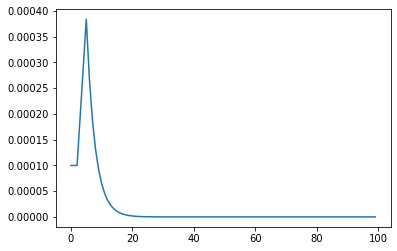

In [17]:
lrs_list = []
for i in range(100):
    lrs_list.append(lrfn(i))
plt.plot(lrs_list)

In [18]:
steps_per_epoch = 560000 // 16 * len(train_files) // Params["batch_size"]
validation_steps = 560000 // 16 * len(val_files) // Params["batch_size"]

In [19]:
from tensorflow.keras import Sequential, layers
with strategy.scope():
    model = Sequential([
        layers.Conv1D(filters=32, activation="relu", kernel_size=16, padding="causal",input_shape=[4096,3]),
        layers.Conv1D(filters=32, activation="relu", kernel_size=16, padding="causal"),
        layers.MaxPool1D(pool_size=4),
        layers.Activation("relu"),
        
        layers.Conv1D(filters=64, activation="relu", kernel_size=8, padding="causal"),
        layers.Conv1D(filters=128, activation="relu", kernel_size=8, padding="causal"),
        layers.Conv1D(filters=128, activation="relu", kernel_size=8, padding="causal"),
        layers.MaxPool1D(pool_size=4),
        layers.Dropout(0.4),
        layers.Activation("relu"),
        
        layers.Conv1D(filters=128, activation="relu", kernel_size=8, padding="causal"),
        layers.Conv1D(filters=128, activation="relu",kernel_size=8, padding="causal"),
        layers.MaxPool1D(pool_size=4),
        layers.Activation("relu"),
        
        layers.Conv1D(filters=256, activation="relu", kernel_size=8, padding="causal"),
        layers.Conv1D(filters=256, activation="relu",kernel_size=8, padding="causal"),
        layers.MaxPool1D(pool_size=4),
        layers.Activation("relu"),
        
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1),
        layers.Activation("sigmoid", dtype="float32")
    ])
    
    lr_decayed_fn = tf.keras.experimental.CosineDecay(
        1e-3,
        steps_per_epoch
    )
    
    opt = tf.keras.optimizers.Adam(learning_rate = Params["lr"])

    #opt = tfa.optimizers.AdamW(lr_decayed_fn, learning_rate = Params["lr"])
    model.compile(
        opt,
        loss="binary_crossentropy",
        metrics=["AUC"]
    )
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4096, 32)          1568      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4096, 32)          16416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1024, 32)          0         
_________________________________________________________________
activation (Activation)      (None, 1024, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1024, 64)          16448     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 128)         65664     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1024, 128)         1

In [20]:
def get_lr_callback(batch_size=8):
    lr_start = Params["lr"]
    lr_max = 0.0000015 * batch_size
    lr_min = 1e-7
    lr_ramp_ep = 3
    lr_sus_ep = 0
    lr_decay = 0.7
    
    def lrfn(epoch):
        initial_epochs = 4
        
        epoch = epoch - initial_epochs
        if epoch < -1 * initial_epochs + 2:
            return lr_start/10
        elif epoch < 0:
            lr = lr_start
        elif epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    return lr_callback

In [21]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2,
    patience=5, min_lr = 0.000001,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=10
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f"{MDL_PATH}/model_{Params['version']:03}.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weight_only=False,
    mode="auto",
    save_freq="epoch"
)

callbacks=[get_lr_callback(Params["batch_size"]) ,reduce_lr, early_stop, model_checkpoint]


In [22]:
history = model.fit(train_ds, validation_data = val_ds, epochs = Params["epochs"], shuffle=True,
                    steps_per_epoch = steps_per_epoch, validation_steps=validation_steps,
                    verbose=1, callbacks=callbacks)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
3828/3828 [==============================] - 177s 44ms/step - loss: 0.6523 - auc: 0.6187 - val_loss: 0.5603 - val_auc: 0.7547
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 1e-05.
3828/3828 [==============================] - 175s 46ms/step - loss: 0.5514 - auc: 0.7626 - val_loss: 0.5388 - val_auc: 0.7753
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
3828/3828 [==============================] - 174s 45ms/step - loss: 0.5038 - auc: 0.8015 - val_loss: 0.4839 - val_auc: 0.8194
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
3828/3828 [==============================] - 175s 46ms/step - loss: 0.4796 - auc: 0.8202 - val_loss: 0.4667 - val_auc: 0.8308
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
3828/3828 [==============================] - 175s 46ms/step - loss: 0.4710 - auc: 0.8266 - va

3828/3828 [==============================] - 199s 52ms/step - loss: 0.4354 - auc: 0.8518 - val_loss: 0.4363 - val_auc: 0.8500
Epoch 38/100

Epoch 00038: LearningRateScheduler setting learning rate to 1.0865285273759673e-07.
3828/3828 [==============================] - 196s 51ms/step - loss: 0.4352 - auc: 0.8519 - val_loss: 0.4363 - val_auc: 0.8501
Epoch 39/100

Epoch 00039: LearningRateScheduler setting learning rate to 1.0605699691631772e-07.
3828/3828 [==============================] - 195s 51ms/step - loss: 0.4354 - auc: 0.8519 - val_loss: 0.4368 - val_auc: 0.8497oss: 0.4355 - auc: - ETA: 8s - loss: 0.435 - ETA: 7s -  - ETA: 5s - loss: 0.4354 - auc: 0.8  - ETA: 2s - loss: 0.435 - ETA: 1s - loss: 0.4354 - auc: 0. - ETA: 1s - loss: 0.4354
Epoch 40/100

Epoch 00040: LearningRateScheduler setting learning rate to 1.042398978414224e-07.
3828/3828 [==============================] - 196s 51ms/step - loss: 0.4355 - auc: 0.8516 - val_loss: 0.4365 - val_auc: 0.8500
Epoch 41/100

Epoch 00041: 

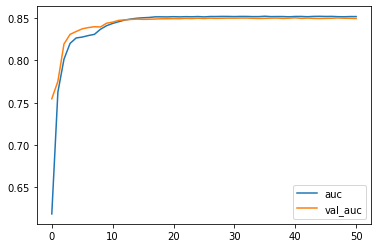

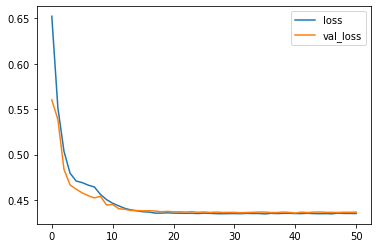

In [23]:
historyFrame = pd.DataFrame(history.history)
historyFrame[["auc", "val_auc"]].plot()
historyFrame[["loss", "val_loss"]].plot()
historyFrame.to_csv(f"{MDL_PATH}/history_mdl{Params['version']:03}.csv", index=False)

In [24]:
historyFrame

,loss,auc,val_loss,val_auc,lr
0,0.652260,0.618672,0.560270,0.754717,1.000000e-05
1,0.551400,0.762610,0.538756,0.775319,1.000000e-05
2,0.503759,0.801465,0.483872,0.819401,1.000000e-04
3,0.479576,0.820172,0.466725,0.830822,1.000000e-04
4,0.470989,0.826586,0.461988,0.834212,1.000000e-04
5,0.469210,0.827651,0.457918,0.837381,1.946667e-04
6,0.466409,0.829439,0.454796,0.838857,2.893333e-04
7,0.464417,0.830851,0.452366,0.839883,3.840000e-04
8,0.456163,0.836910,0.454216,0.839611,2.688300e-04
9,0.450514,0.841071,0.444553,0.843993,1.882110e-04


In [25]:
best_epoch = historyFrame.val_auc.argmax()
best_loss = historyFrame.iloc[best_epoch].loss
best_auc = historyFrame.iloc[best_epoch].val_auc
print("best epoch:", best_epoch,
      "| best loss:", best_loss,
      "| best auc:", best_auc
     )

best epoch: 40 | best loss: 0.43519923090934753 | best auc: 0.850387454032898


In [26]:
result = Params.copy()
result["bavg_epoch"] = int(best_epoch)
result["bavg_loss"] = float(best_loss)
result["bavg_auc"] = float(best_auc)
with open(f"{MDL_PATH}/params.json", "w") as file:
    json.dump(result, file)

if not os.path.exists(f"{MDLS_PATH}/results.csv"):
    df_save = pd.DataFrame(result, index=[0])
    df_save.to_csv(f"{MDLS_PATH}/results.csv")
else:
    df_old = pd.read_csv(f"{MDLS_PATH}/results.csv", index_col=0)
    df_save = pd.DataFrame(result, index = [df_old.index.max() + 1])
    df_save = df_old.append(df_save, ignore_index=True)
    df_save.to_csv(f"{MDLS_PATH}/results.csv")   

In [27]:
pd.read_csv(f"{MDLS_PATH}/results.csv",index_col=[0])

,lr,version,train_mode,batch_size,epochs,bavg_epoch,bavg_loss,bavg_auc,changelog,seed
0,0.00100,1,full,256,60,16,0.451789,0.838065,NaN,NaN
1,0.00100,2,test,256,60,13,0.449180,0.822957,moved all relu layers before the pooling layers,NaN
2,0.00100,3,full,256,60,20,0.442866,0.837724,"tried on large ds, since hight overfitting",NaN
3,0.00100,5,test,256,60,13,0.449431,0.822973,added second layer to first block or reference,NaN
4,0.00100,6,test,256,30,9,0.442229,0.820143,added relu activations to all conv layers,NaN
5,0.00100,9,test,256,30,4,0.480765,0.812309,set all pool sizes to 1,NaN
6,0.00100,11,test,256,30,8,0.438630,0.819107,set all pool sizes to 8,NaN
7,0.00100,13,test,256,30,12,0.448575,0.820421,added second layer to first block with small k...,NaN
8,0.00010,14,test,256,30,12,0.457616,0.820876,added second layer to first block with small k...,NaN
9,0.00010,17,test,64,30,6,0.475783,0.814108,trial of completely different achitecture,NaN


In [28]:
del train_ds, val_ds
gc.collect()

7463

In [29]:
all_train_files

[array(['../input/filtered-whitened-tfrec\\train_00.tfrec',
        '../input/filtered-whitened-tfrec\\train_01.tfrec',
        '../input/filtered-whitened-tfrec\\train_02.tfrec',
        '../input/filtered-whitened-tfrec\\train_03.tfrec',
        '../input/filtered-whitened-tfrec\\train_04.tfrec',
        '../input/filtered-whitened-tfrec\\train_05.tfrec',
        '../input/filtered-whitened-tfrec\\train_06.tfrec',
        '../input/filtered-whitened-tfrec\\train_07.tfrec',
        '../input/filtered-whitened-tfrec\\train_08.tfrec',
        '../input/filtered-whitened-tfrec\\train_09.tfrec',
        '../input/filtered-whitened-tfrec\\train_10.tfrec',
        '../input/filtered-whitened-tfrec\\train_11.tfrec',
        '../input/filtered-whitened-tfrec\\train_12.tfrec',
        '../input/filtered-whitened-tfrec\\train_13.tfrec',
        '../input/filtered-whitened-tfrec\\train_14.tfrec',
        '../input/filtered-whitened-tfrec\\train_15.tfrec'], dtype='<U47'),
 array(['../input/whiten

In [30]:
prediction_scores = []
with strategy.scope():
    model = tf.keras.models.load_model(f"{MDL_PATH}/model_{Params['version']:03}.h5")
train_df = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")
for ds_ind in range(len(all_train_files)):
    train_set = load_dataset(all_train_files[ds_ind], shuffle=False, ordered=True, labeled=True, repeat=False, return_labels=False)
    prediction = model.predict(train_set)
    tf.keras.backend.clear_session()
    gc.collect()
    prediction_scores.append(roc_auc_score(train_df.target, prediction))
print(prediction_scores)
best_pred = np.array(prediction_scores).argmax()

[0.8560393182154675, 0.8589913199752228]


In [31]:
test_set = load_dataset(test_files[best_pred], shuffle=False, ordered=True, labeled=False, repeat=False, return_labels=False)
test_prediction = model.predict(test_set)
sub = pd.read_csv("../input/g2net-gravitational-wave-detection/sample_submission.csv")
sub.target = test_prediction.flatten()
sub.to_csv(f"{MDL_PATH}/submission.csv", index=False)